In [83]:
import numpy as np
from keras import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

from scipy.stats import ttest_rel
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout, Dense, Bidirectional, GlobalMaxPool1D, LSTM

import prepare_data as prep
from prepare_data import DataPreprocessor
from importlib import reload
import matplotlib.pyplot as plt

reload(prep)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Radosz\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Radosz\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Radosz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<module 'prepare_data' from 'd:\\Projects\\toxic-comment-classification\\prepare_data.py'>

In [60]:
prepData = DataPreprocessor("jigsaw-toxic-comment-classification-challenge/train.csv")

prepData.load_data()
prepData.preprocess_data()
X, y = prepData.get_XY()

                      id                                       comment_text  \
0       0000997932d777bf  explanation\nwhy the edits made under my usern...   
1       000103f0d9cfb60f  d'aww! he matches this background colour i'm s...   
2       000113f07ec002fd  hey man, i'm really not trying to edit war. it...   
3       0001b41b1c6bb37e  "\nmore\ni can't make any real suggestions on ...   
4       0001d958c54c6e35  you, sir, are my hero. any chance you remember...   
...                  ...                                                ...   
159566  ffe987279560d7ff  ":::::and for the second time of asking, when ...   
159567  ffea4adeee384e90  you should be ashamed of yourself \n\nthat is ...   
159568  ffee36eab5c267c9  spitzer \n\numm, theres no actual article for ...   
159569  fff125370e4aaaf3  and it looks like it was actually you who put ...   
159570  fff46fc426af1f9a  "\nand ... i really don't think you understand...   

        toxic  severe_toxic  obscene  threat  insul

In [61]:
# Zmniana wartości klas w binarne

mlb = LabelBinarizer()
y_binary = mlb.fit_transform(y)

X_notoken = X

# Tokenizacja danych tekstowych
max_words = 20000
max_len = 150
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X)
X_seq = tokenizer.texts_to_sequences(X)
X_padded = pad_sequences(X_seq, maxlen=max_len)

# Podział metodą train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_padded, y_binary, test_size=0.2, random_state=42)

print("X_train", X_train.shape)
print("X_test", X_test.shape)
print("y_train", y_train.shape)
print("y_test", y_test.shape)


X_train (127656, 150)
X_test (31915, 150)
y_train (127656, 6)
y_test (31915, 6)


In [62]:
X_train2=X_train[::10]
y_train2=y_train[::10]
X_test2=X_test[::10]
y_test2=y_test[::10]

print("X_train", X_train.shape)
print("X_test", X_test.shape)
print("y_train", y_train.shape)
print("y_test", y_test.shape)

X_train (12766, 150)
X_test (3192, 150)
y_train (12766, 6)
y_test (3192, 6)


In [63]:
# LR preparation

# Dodać walidację krzyżową do każdego modelu oraz testy statystyczne

from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV

param_distributions = {
    'C': uniform(loc=0.01, scale=10),
    'penalty': ['l2']
}

random_search_LR = RandomizedSearchCV(
    estimator=LogisticRegression(solver='lbfgs', max_iter=1000, verbose=True),
    param_distributions=param_distributions,
    n_iter=4,
    cv=3,
    random_state=42,
    scoring='f1'
)

def LR_Training_CV(y_label, X_padded, tokenizer, k=5):
    # Perform parameter search on the entire dataset
    X_text = [' '.join(tokenizer.sequences_to_texts([comment])[0].split()) for comment in X_padded]
    
    tfidf_vec = TfidfVectorizer(max_df=0.7)
    X_vec = tfidf_vec.fit_transform(X_text)
    
    random_search_LR.fit(X_vec, y_label.values.ravel())
    best_params = random_search_LR.best_params_
    print('Best parameters from RandomizedSearchCV:', best_params)
    
    # Use the best parameters for cross-validation
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
    all_predictions = []
    all_y_tests = []
    
    for train_index, test_index in kf.split(X_padded):
        X_train_LR, X_test_LR = X_padded[train_index], X_padded[test_index]
        y_train_LR, y_test_LR = y_label.iloc[train_index], y_label.iloc[test_index]
        
        X_train_LR = [' '.join(tokenizer.sequences_to_texts([comment])[0].split()) for comment in X_train_LR]
        X_test_LR = [' '.join(tokenizer.sequences_to_texts([comment])[0].split()) for comment in X_test_LR]
        
        tfidf_vec = TfidfVectorizer(max_df=0.7)
        X_train_LR_vec = tfidf_vec.fit_transform(X_train_LR)
        X_test_LR_vec = tfidf_vec.transform(X_test_LR)
        
        model = LogisticRegression(solver='lbfgs', max_iter=1000, verbose=True, **best_params)
        model.fit(X_train_LR_vec, y_train_LR.values.ravel())
        
        predictions = model.predict(X_test_LR_vec)
        
        all_predictions.extend(predictions)
        all_y_tests.extend(y_test_LR.values)
    
    print(confusion_matrix(all_y_tests, all_predictions))
    print(classification_report(all_y_tests, all_predictions))
    accuracy = accuracy_score(all_y_tests, all_predictions)
    report = classification_report(all_y_tests, all_predictions, output_dict=True)

    return accuracy, report['weighted avg']['precision'], report['weighted avg']['recall'], report['weighted avg']['f1-score']

In [65]:
# NB Preparation

param_distributions = {
    'alpha': uniform(loc=0, scale=1),
    'fit_prior': [True, False]
}

random_search_NB = RandomizedSearchCV(
    estimator=MultinomialNB(),
    param_distributions=param_distributions,
    n_iter=4,
    cv=3,
    random_state=42,
    scoring='f1'
)


def NB_Training_CV(y_label, X_padded, tokenizer, k=5):
    # Perform parameter search on the entire dataset
    X_text = [' '.join(tokenizer.sequences_to_texts([comment])[0].split()) for comment in X_padded]

    tfidf_vec = TfidfVectorizer(max_df=0.7)
    X_vec = tfidf_vec.fit_transform(X_text)

    random_search_NB.fit(X_vec, y_label.values.ravel())
    best_params = random_search_NB.best_params_
    print('Best parameters from RandomizedSearchCV:', best_params)

    # Use the best parameters for cross-validation
    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    all_predictions = []
    all_y_tests = []

    for train_index, test_index in kf.split(X_padded):
        X_train_NB, X_test_NB = X_padded[train_index], X_padded[test_index]
        y_train_NB, y_test_NB = y_label.iloc[train_index], y_label.iloc[test_index]

        X_train_NB = [' '.join(tokenizer.sequences_to_texts([comment])[0].split()) for comment in X_train_NB]
        X_test_NB = [' '.join(tokenizer.sequences_to_texts([comment])[0].split()) for comment in X_test_NB]

        tfidf_vec = TfidfVectorizer(max_df=0.7)
        X_train_NB_vec = tfidf_vec.fit_transform(X_train_NB)
        X_test_NB_vec = tfidf_vec.transform(X_test_NB)

        model = MultinomialNB(**best_params)
        model.fit(X_train_NB_vec, y_train_NB.values.ravel())

        predictions = model.predict(X_test_NB_vec)

        all_predictions.extend(predictions)
        all_y_tests.extend(y_test_NB.values)

    print(confusion_matrix(all_y_tests, all_predictions))
    print(classification_report(all_y_tests, all_predictions))

     # Calculate and return metrics
    report = classification_report(all_y_tests, all_predictions, output_dict=True)
    accuracy = accuracy_score(all_y_tests, all_predictions)
    print('Accuracy:', accuracy)
    return accuracy, report['weighted avg']['precision'], report['weighted avg']['recall'], report['weighted avg']['f1-score']


In [66]:
results = {
    'Regresja_Liniowa': {'accuracy': 0.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0},
    'Naive_Bayes': {'accuracy': 0.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0},
    'CNN': {'accuracy': 0.90, 'precision': 0.87, 'recall': 0.85, 'f1_score': 0.86},
    'LSTM': {'accuracy': 0.89, 'precision': 0.85, 'recall': 0.84, 'f1_score': 0.84}
}


categories = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
for category in categories:
    print(f"{category} comments NB:")
    accuracy, precision, recall, f1_score = NB_Training_CV(y[[category]], X_padded, tokenizer)
    results['Naive_Bayes']['accuracy'] += accuracy
    results['Naive_Bayes']['precision'] += precision
    results['Naive_Bayes']['recall'] += recall
    results['Naive_Bayes']['f1_score'] += f1_score

    print(f"{category} comments LR:")
    accuracy, precision, recall, f1_score = LR_Training_CV(y[[category]], X_padded, tokenizer)
    results['Regresja_Liniowa']['accuracy'] += accuracy
    results['Regresja_Liniowa']['precision'] += precision
    results['Regresja_Liniowa']['recall'] += recall
    results['Regresja_Liniowa']['f1_score'] += f1_score

# Średnie wyniki dla wszystkich kategorii
results['Naive_Bayes']['accuracy'] /= len(categories)
results['Naive_Bayes']['precision'] /= len(categories)
results['Naive_Bayes']['recall'] /= len(categories)
results['Naive_Bayes']['f1_score'] /= len(categories)
results['Regresja_Liniowa']['accuracy'] /= len(categories)
results['Regresja_Liniowa']['precision'] /= len(categories)
results['Regresja_Liniowa']['recall'] /= len(categories)
results['Regresja_Liniowa']['f1_score'] /= len(categories)

toxic comments NB:
Best parameters from RandomizedSearchCV: {'alpha': 0.3745401188473625, 'fit_prior': True}
[[143447    830]
 [  7270   8024]]
              precision    recall  f1-score   support

           0       0.95      0.99      0.97    144277
           1       0.91      0.52      0.66     15294

    accuracy                           0.95    159571
   macro avg       0.93      0.76      0.82    159571
weighted avg       0.95      0.95      0.94    159571

Accuracy: 0.9492388967920237
toxic comments LR:
Best parameters from RandomizedSearchCV: {'C': 7.3299394181140505, 'penalty': 'l2'}
[[142621   1656]
 [  4909  10385]]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98    144277
           1       0.86      0.68      0.76     15294

    accuracy                           0.96    159571
   macro avg       0.91      0.83      0.87    159571
weighted avg       0.96      0.96      0.96    159571

severe_toxic comments NB:
Best para

In [67]:
print("Results for Naive Bayes:")
print(results['Naive_Bayes'])
print("Results for Logistic Regression:")
print(results['Regresja_Liniowa'])

Results for Naive Bayes:
{'accuracy': 0.9420153620227568, 'precision': 0.9762886514003092, 'recall': 0.9420153620227568, 'f1_score': 0.9554274681219587}
Results for Logistic Regression:
{'accuracy': 0.9813238829946127, 'precision': 0.9795794651889684, 'recall': 0.9813238829946127, 'f1_score': 0.9798306779190793}


In [8]:
import tensorflow as tf

def f1_score(y_true, y_pred):
    y_pred = tf.round(tf.clip_by_value(y_pred, 0, 1))
    true_positives = tf.reduce_sum(y_true * y_pred)
    false_positives = tf.reduce_sum((1 - y_true) * y_pred)
    false_negatives = tf.reduce_sum(y_true * (1 - y_pred))

    precision = true_positives / (true_positives + false_positives + tf.keras.backend.epsilon())
    recall = true_positives / (true_positives + false_negatives + tf.keras.backend.epsilon())
    
    f1_score = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())

    return f1_score

In [42]:
# Define the hyperparameter space
space = {
    'max_len': hp.choice('max_len', [100, 200, 300]),
    'embed_dim': hp.choice('embed_dim', [64, 128, 256]),
    'filters': hp.choice('filters', [64, 128, 256]),
    'kernel_size': hp.choice('kernel_size', [3, 5, 7]),
    'dense_units': hp.choice('dense_units', [64, 128, 256]),
    'dropout_rate': hp.uniform('dropout_rate', 0.2, 0.5),
    'batch_size': hp.choice('batch_size', [32, 64, 128]),
    'epochs': hp.choice('epochs', [3]),
}

def pad_sequences_custom(sequences, max_len):
    return np.array([np.pad(seq, (0, max_len - len(seq)), mode='constant')[:max_len] for seq in sequences])

def objective(params):
    # Cross-validation setup
    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    val_scores_cnn = []
    
    # Define the CNN model
    inputs = Input(shape=(params['max_len'],))
    embedding = Embedding(input_dim=max_words, output_dim=params['embed_dim'], input_length=params['max_len'])(inputs)
    conv1 = Conv1D(filters=params['filters'], kernel_size=params['kernel_size'], activation='relu')(embedding)
    pool1 = MaxPooling1D(pool_size=2)(conv1)
    conv2 = Conv1D(filters=params['filters'], kernel_size=params['kernel_size'], activation='relu')(pool1)
    pool2 = GlobalMaxPooling1D()(conv2)
    dense1 = Dense(params['dense_units'], activation='relu')(pool2)
    dropout = Dropout(params['dropout_rate'])(dense1)
    outputs = Dense(6, activation='sigmoid')(dropout)
    model = Model(inputs=inputs, outputs=outputs)
    
    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    for train_index, val_index in kf.split(X_train2):
        print(train_index)
        X_train_fold, X_val_fold = X_train2[train_index], X_train2[val_index]
        y_train_fold, y_val_fold = y_train2[train_index], y_train2[val_index]

        # Adjust the input data to match max_len
        X_train_fold = pad_sequences_custom(X_train_fold, params['max_len'])
        X_val_fold = pad_sequences_custom(X_val_fold, params['max_len'])
        
        # Define callbacks
        checkpoint = ModelCheckpoint('best_model_cnn.keras', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
        early_stop = EarlyStopping(monitor='val_loss', patience=2, mode='min', verbose=1)

        # Train the model
        history_cnn = model.fit(X_train_fold, y_train_fold, epochs=params['epochs'], batch_size=params['batch_size'], validation_data=(X_val_fold, y_val_fold), callbacks=[checkpoint, early_stop])

        # Evaluate the model
        val_preds = model.predict(X_val_fold)
        val_preds_binary = (val_preds > 0.5).astype(int)
        f1 = f1_score(y_val_fold, val_preds_binary, average='macro')
        val_scores_cnn.append(f1)

    # Calculate the average F1 score over all folds
    avg_f1 = np.mean(val_scores_cnn)
    
    # Return the negative average F1 score to minimize
    return {'loss': -avg_f1, 'status': STATUS_OK}

# Initialize Trials object to keep track of results
trials = Trials()

# Run hyperparameter optimization
best_cnn = fmin(objective, space, algo=tpe.rand.suggest, max_evals=2, trials=trials)

# Print the best hyperparameters
print('Best hyperparameters:', best_cnn)

[    1     2     4 ... 12758 12763 12765]            
Epoch 1/3                                            

  1/133 ━━━━━━━━━━━━━━━━━━━━ 5:16 2s/step - accuracy: 0.7188 - loss: 0.6837
  2/133 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - accuracy: 0.6953 - loss: 0.6718
  3/133 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - accuracy: 0.6753 - loss: 0.6595
  4/133 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.6598 - loss: 0.6457
  5/133 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - accuracy: 0.6472 - loss: 0.6283
  6/133 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - accuracy: 0.6409 - loss: 0.6084
  7/133 ━━━━━━━━━━━━━━━━━━━━ 9s 79ms/step - accuracy: 0.6387 - loss: 0.5866 
  8/133 ━━━━━━━━━━━━━━━━━━━━ 9s 80ms/step - accuracy: 0.6384 - loss: 0.5687
  9/133 ━━━━━━━━━━━━━━━━━━━━ 9s 80ms/step - accuracy: 0.6385 - loss: 0.5515
 10/133 ━━━━━━━━━━━━━━━━━━━━ 9s 80ms/step - accuracy: 0.6396 - loss: 0.5360
 11/133 ━━━━━━━━━━━━━━━━━━━━ 9s 80ms/step - accuracy: 0.6423 - loss: 0.5211
 12/133 ━━━━━━━━━━━━━━━━━━━━ 9s 80ms/step - accur

d:\Projects\toxic-comment-classification\venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(



Epoch 1/3                                                                        

  1/266 ━━━━━━━━━━━━━━━━━━━━ 10:33 2s/step - accuracy: 0.2188 - loss: 0.6966
  6/266 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.1084 - loss: 0.6813 
 11/266 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.0812 - loss: 0.6532
 16/266 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.0705 - loss: 0.6044
 21/266 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.0860 - loss: 0.5632
 26/266 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.1252 - loss: 0.5277
 30/266 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.1597 - loss: 0.5026
 35/266 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.1966 - loss: 0.4755
 40/266 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.2254 - loss: 0.4522
 45/266 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.2504 - loss: 0.4324
 50/266 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.2729 - loss: 0.4150
 55/266 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.2925 - loss: 0.4000
 60

In [44]:
# LSTM Parameter Optimization

space = {
    'max_len': hp.choice('max_len', [100, 200, 300]),
    'embed_dim': hp.choice('embed_dim', [64, 128, 256]),
    'lstm_units': hp.choice('lstm_units', [32, 64, 128]),
    'recurrent_dropout': hp.uniform('recurrent_dropout', 0.1, 0.3),
    'dense_units': hp.choice('dense_units', [32, 64, 128]),
    'dropout_rate': hp.uniform('dropout_rate', 0.1, 0.4),
    'batch_size': hp.choice('batch_size', [64, 128, 256]),
    'epochs': hp.choice('epochs', [3]),
}

def objective(params):
    # Cross-validation setup
    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    val_scores_lstm = []
    inputs = Input(shape=(params['max_len'],))
    layer = Embedding(input_dim=max_words, output_dim=params['embed_dim'], input_length=params['max_len'])(inputs)
    layer = Bidirectional(LSTM(params['lstm_units'], return_sequences=True, recurrent_dropout=params['recurrent_dropout']))(layer)
    layer = GlobalMaxPool1D()(layer)
    layer = Dropout(params['dropout_rate'])(layer)
    layer = Dense(params['dense_units'], activation='relu')(layer)
    layer = Dropout(params['dropout_rate'])(layer)
    layer = Dense(6, activation='sigmoid')(layer)
    model = Model(inputs=inputs, outputs=layer)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


    for train_index, val_index in kf.split(X_train2):
        X_train_fold, X_val_fold = X_train2[train_index], X_train2[val_index]
        y_train_fold, y_val_fold = y_train2[train_index], y_train2[val_index]

        # Adjust the input data to match max_len
        X_train_fold = pad_sequences_custom(X_train_fold, params['max_len'])
        X_val_fold = pad_sequences_custom(X_val_fold, params['max_len'])
    
        checkpoint = ModelCheckpoint('save_best_model_lstm.keras', monitor='val_loss', verbose=1, save_best_only=True)
        early_stop = EarlyStopping(monitor='val_loss', patience=1)

        history_lstm = model.fit(X_train_fold, y_train_fold, batch_size=params['batch_size'], epochs=params['epochs'], validation_split=0.2, callbacks=[checkpoint, early_stop])

        # Evaluate the model
        val_preds = model.predict(X_val_fold)
        val_preds_binary = (val_preds > 0.5).astype(int)
        f1 = f1_score(y_val_fold, val_preds_binary, average='macro')
        val_scores_lstm.append(f1)

    # Calculate the average F1 score over all folds
    avg_f1 = np.mean(val_scores_lstm)

    return {'loss': -avg_f1, 'status': STATUS_OK}

trials = Trials()

best_lstm = fmin(objective, space, algo=tpe.rand.suggest, max_evals=2, trials=trials)

print('Best hyperparameters:', best_lstm)

[    1     2     4 ... 12758 12763 12765]            
Epoch 1/3                                            

 1/54 ━━━━━━━━━━━━━━━━━━━━ 4:44 5s/step - accuracy: 0.0078 - loss: 0.6943
 2/54 ━━━━━━━━━━━━━━━━━━━━ 11s 213ms/step - accuracy: 0.0117 - loss: 0.6907
 3/54 ━━━━━━━━━━━━━━━━━━━━ 12s 250ms/step - accuracy: 0.0122 - loss: 0.6867
 4/54 ━━━━━━━━━━━━━━━━━━━━ 12s 246ms/step - accuracy: 0.0135 - loss: 0.6817
 5/54 ━━━━━━━━━━━━━━━━━━━━ 11s 234ms/step - accuracy: 0.0139 - loss: 0.6755
 6/54 ━━━━━━━━━━━━━━━━━━━━ 10s 228ms/step - accuracy: 0.0142 - loss: 0.6677
 7/54 ━━━━━━━━━━━━━━━━━━━━ 10s 224ms/step - accuracy: 0.0149 - loss: 0.6582
 8/54 ━━━━━━━━━━━━━━━━━━━━ 10s 225ms/step - accuracy: 0.0155 - loss: 0.6475
 9/54 ━━━━━━━━━━━━━━━━━━━━ 10s 227ms/step - accuracy: 0.0165 - loss: 0.6355
10/54 ━━━━━━━━━━━━━━━━━━━━ 9s 225ms/step - accuracy: 0.0182 - loss: 0.6235 
11/54 ━━━━━━━━━━━━━━━━━━━━ 9s 223ms/step - accuracy: 0.0204 - loss: 0.6109
12/54 ━━━━━━━━━━━━━━━━━━━━ 9s 221ms/step - accuracy: 0.022

d:\Projects\toxic-comment-classification\venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(



Epoch 1/3                                                                         

 1/54 ━━━━━━━━━━━━━━━━━━━━ 5:37 6s/step - accuracy: 0.0234 - loss: 0.6935
 2/54 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - accuracy: 0.0234 - loss: 0.6898
 3/54 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - accuracy: 0.0252 - loss: 0.6863
 4/54 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - accuracy: 0.0282 - loss: 0.6827
 5/54 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - accuracy: 0.0316 - loss: 0.6789
 6/54 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - accuracy: 0.0344 - loss: 0.6753
 7/54 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - accuracy: 0.0373 - loss: 0.6715
 8/54 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - accuracy: 0.0399 - loss: 0.6675
 9/54 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - accuracy: 0.0421 - loss: 0.6634
10/54 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - accuracy: 0.0436 - loss: 0.6594
11/54 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 0.0453 - loss: 0.6554
12/54 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 0.0469 - loss: 0.6513
13/54 ━━━━━━━━━━━━━━━━━━━━ 3

In [47]:
# Map best indices to actual values
best_cnn['max_len'] = [100, 200, 300][best_cnn['max_len']]
best_cnn['embed_dim'] = [64, 128, 256][best_cnn['embed_dim']]
best_cnn['kernel_size'] = [3, 5, 7][best_cnn['kernel_size']]
best_cnn['filters'] = [64, 128, 256][best_cnn['filters']]
best_cnn['dense_units'] = [32, 64, 128][best_cnn['dense_units']]
best_cnn['batch_size'] = [64, 128, 256][best_cnn['batch_size']]
best_cnn['epochs'] = [3][best_cnn['epochs']]  # Only one choice, but maintaining structure

print('Best hyperparameters CNN:', best_cnn)

# Map best indices to actual values
best_lstm['max_len'] = [100, 200, 300][best_lstm['max_len']]
best_lstm['embed_dim'] = [64, 128, 256][best_lstm['embed_dim']]
best_lstm['lstm_units'] = [32, 64, 128][best_lstm['lstm_units']]
best_lstm['dense_units'] = [32, 64, 128][best_lstm['dense_units']]
best_lstm['batch_size'] = [64, 128, 256][best_lstm['batch_size']]
best_lstm['epochs'] = [3][best_lstm['epochs']]  # Only one choice, but maintaining structure

print('Best hyperparameters LSTM:', best_lstm)

Best hyperparameters CNN: {'batch_size': 128, 'dense_units': 64, 'dropout_rate': 0.20693163905050424, 'embed_dim': 256, 'epochs': 3, 'filters': 256, 'kernel_size': 3, 'max_len': 200}
Best hyperparameters CNN: {'batch_size': 128, 'dense_units': 32, 'dropout_rate': 0.3021400220523167, 'embed_dim': 128, 'epochs': 3, 'lstm_units': 32, 'max_len': 200, 'recurrent_dropout': 0.28202504542899054}


d:\Projects\toxic-comment-classification\venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


[    1     2     4 ... 12758 12763 12765]
Epoch 1/5
53/54 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.3897 - loss: 0.5589
Epoch 1: val_loss improved from inf to 0.18244, saving model to save_best_model_lstm.keras
54/54 ━━━━━━━━━━━━━━━━━━━━ 11s 98ms/step - accuracy: 0.3873 - loss: 0.5537 - val_accuracy: 0.0018 - val_loss: 0.1824
Epoch 2/5
53/54 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.3646 - loss: 0.2084
Epoch 2: val_loss improved from 0.18244 to 0.17224, saving model to save_best_model_lstm.keras
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - accuracy: 0.3657 - loss: 0.2078 - val_accuracy: 0.9324 - val_loss: 0.1722
Epoch 3/5
53/54 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.4341 - loss: 0.1844
Epoch 3: val_loss improved from 0.17224 to 0.15504, saving model to save_best_model_lstm.keras
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - accuracy: 0.4345 - loss: 0.1840 - val_accuracy: 0.9941 - val_loss: 0.1550
Epoch 4/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.5273 - loss:

d:\Projects\toxic-comment-classification\venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  # we assume the user will be removing warnings if zero_division is set


Epoch 1/5
53/54 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.5815 - loss: 0.0669
Epoch 1: val_loss improved from inf to 0.05832, saving model to save_best_model_lstm.keras
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - accuracy: 0.5816 - loss: 0.0669 - val_accuracy: 0.9971 - val_loss: 0.0583
Epoch 2/5
53/54 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.6678 - loss: 0.0535
Epoch 2: val_loss did not improve from 0.05832
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - accuracy: 0.6678 - loss: 0.0535 - val_accuracy: 0.9971 - val_loss: 0.0606
133/133 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
[    0     3     8 ... 12762 12764 12765]


d:\Projects\toxic-comment-classification\venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  # we assume the user will be removing warnings if zero_division is set


Epoch 1/5
53/54 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.6712 - loss: 0.0505
Epoch 1: val_loss improved from inf to 0.06385, saving model to save_best_model_lstm.keras
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - accuracy: 0.6717 - loss: 0.0505 - val_accuracy: 0.9947 - val_loss: 0.0639
Epoch 2/5
53/54 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.7202 - loss: 0.0436
Epoch 2: val_loss did not improve from 0.06385
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - accuracy: 0.7203 - loss: 0.0437 - val_accuracy: 0.9947 - val_loss: 0.0708
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


d:\Projects\toxic-comment-classification\venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  # we assume the user will be removing warnings if zero_division is set


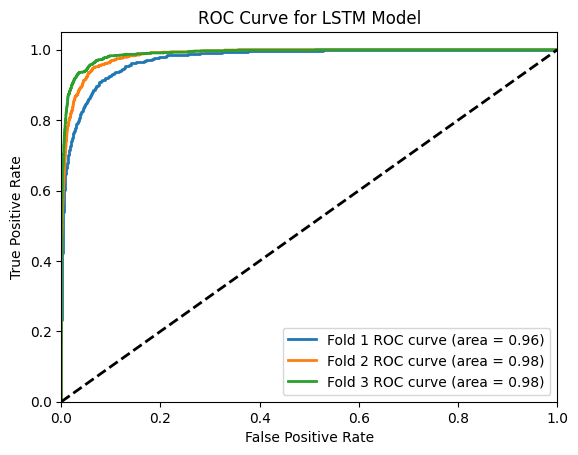

In [84]:

# Cross-validation setup
kf = KFold(n_splits=3, shuffle=True, random_state=42)
val_scores_lstm = []
inputs = Input(shape=(200,))
layer = Embedding(input_dim=max_words, output_dim=128, input_length=200)(inputs)
layer = Bidirectional(LSTM(32, return_sequences=True, recurrent_dropout=0.28))(layer)
layer = GlobalMaxPool1D()(layer)
layer = Dropout(0.30)(layer)
layer = Dense(32, activation='relu')(layer)
layer = Dropout(0.30)(layer)
layer = Dense(6, activation='sigmoid')(layer)
model = Model(inputs=inputs, outputs=layer)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

lstm_val_scores_f1 = []
lstm_val_scores_precision = []
lstm_val_scores_recall = []
lstm_val_scores_accuracy = []
lstm_roc_auc = []
lstm_fpr = []
lstm_tpr = []

for train_index, val_index in kf.split(X_train):
    print(train_index)
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Adjust the input data to match max_len
    X_train_fold = pad_sequences_custom(X_train_fold, 200)
    X_val_fold = pad_sequences_custom(X_val_fold, 200)

    checkpoint = ModelCheckpoint('save_best_model_lstm.keras', monitor='val_loss', verbose=1, save_best_only=True)
    early_stop = EarlyStopping(monitor='val_loss', patience=1)

    history_lstm = model.fit(X_train_fold, y_train_fold, batch_size=128, epochs=5, validation_split=0.2, callbacks=[checkpoint, early_stop])

    # Evaluate the model
    val_preds = model.predict(X_val_fold)
    val_preds_binary = (val_preds > 0.5).astype(int)
    
    f1 = f1_score(y_val_fold, val_preds_binary, average='macro')
    precision = precision_score(y_val_fold, val_preds_binary, average='macro')
    recall = recall_score(y_val_fold, val_preds_binary, average='macro')
    accuracy = accuracy_score(y_val_fold, val_preds_binary)

    lstm_val_scores_f1.append(f1)
    lstm_val_scores_precision.append(precision)
    lstm_val_scores_recall.append(recall)
    lstm_val_scores_accuracy.append(accuracy)
    # Calculate ROC AUC for all classes together
    auc = roc_auc_score(y_val_fold, val_preds, average='macro')
    fpr, tpr, _ = roc_curve(y_val_fold.ravel(), val_preds.ravel())
    lstm_roc_auc.append(auc)
    lstm_fpr.append(fpr)
    lstm_tpr.append(tpr)


# Plot ROC curves for all classes together
plt.figure()

# Plot each fold's ROC curve
for i in range(len(lstm_fpr)):  # Each fold
    plt.plot(lstm_fpr[i], lstm_tpr[i], lw=2, label=f'Fold {i+1} ROC curve (area = {lstm_roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for LSTM Model')
plt.legend(loc="lower right")
plt.show()

d:\Projects\toxic-comment-classification\venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


[    1     2     4 ... 12758 12763 12765]
Epoch 1/5
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.3706 - loss: 0.3039
Epoch 1: val_loss improved from inf to 0.11105, saving model to best_model_cnn.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 13s 153ms/step - accuracy: 0.3727 - loss: 0.3024 - val_accuracy: 0.9948 - val_loss: 0.1110
Epoch 2/5
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.6336 - loss: 0.1165
Epoch 2: val_loss improved from 0.11105 to 0.09199, saving model to best_model_cnn.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 10s 150ms/step - accuracy: 0.6340 - loss: 0.1164 - val_accuracy: 0.9948 - val_loss: 0.0920
Epoch 3/5
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.7723 - loss: 0.0694
Epoch 3: val_loss improved from 0.09199 to 0.07232, saving model to best_model_cnn.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 10s 157ms/step - accuracy: 0.7722 - loss: 0.0693 - val_accuracy: 0.9948 - val_loss: 0.0723
Epoch 4/5
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.7612 - loss: 0.0439
E

d:\Projects\toxic-comment-classification\venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  # we assume the user will be removing warnings if zero_division is set


Epoch 1/5
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.7621 - loss: 0.0524
Epoch 1: val_loss improved from inf to 0.03423, saving model to best_model_cnn.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 11s 170ms/step - accuracy: 0.7617 - loss: 0.0524 - val_accuracy: 0.9944 - val_loss: 0.0342
Epoch 2/5
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.7552 - loss: 0.0310
Epoch 2: val_loss improved from 0.03423 to 0.03396, saving model to best_model_cnn.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 11s 167ms/step - accuracy: 0.7550 - loss: 0.0310 - val_accuracy: 0.9944 - val_loss: 0.0340
Epoch 3/5
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.7460 - loss: 0.0264
Epoch 3: val_loss did not improve from 0.03396
67/67 ━━━━━━━━━━━━━━━━━━━━ 11s 168ms/step - accuracy: 0.7460 - loss: 0.0264 - val_accuracy: 0.9932 - val_loss: 0.0354
Epoch 4/5
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.6760 - loss: 0.0223
Epoch 4: val_loss did not improve from 0.03396
67/67 ━━━━━━━━━━━━━━━━━━━━ 11s 163ms/s

d:\Projects\toxic-comment-classification\venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  # we assume the user will be removing warnings if zero_division is set


Epoch 1/5
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.5466 - loss: 0.0307
Epoch 1: val_loss improved from inf to 0.01951, saving model to best_model_cnn.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 11s 160ms/step - accuracy: 0.5463 - loss: 0.0307 - val_accuracy: 0.5208 - val_loss: 0.0195
Epoch 2/5
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.5183 - loss: 0.0234
Epoch 2: val_loss improved from 0.01951 to 0.01886, saving model to best_model_cnn.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step - accuracy: 0.5178 - loss: 0.0234 - val_accuracy: 0.8564 - val_loss: 0.0189
Epoch 3/5
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.5340 - loss: 0.0198
Epoch 3: val_loss did not improve from 0.01886
67/67 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 0.5323 - loss: 0.0198 - val_accuracy: 0.4026 - val_loss: 0.0194
Epoch 4/5
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.4152 - loss: 0.0168
Epoch 4: val_loss did not improve from 0.01886
67/67 ━━━━━━━━━━━━━━━━━━━━ 10s 149ms/s

d:\Projects\toxic-comment-classification\venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  # we assume the user will be removing warnings if zero_division is set


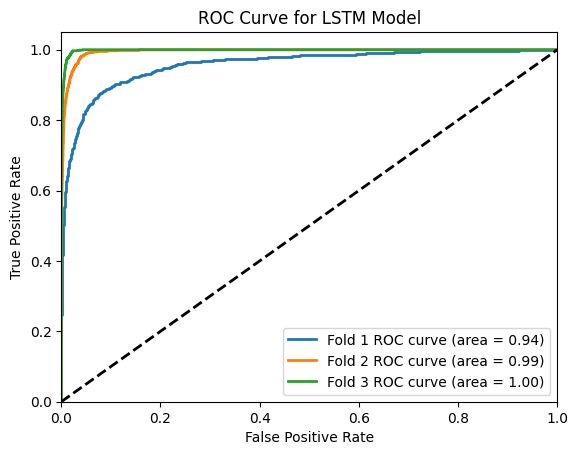

In [85]:

kf = KFold(n_splits=3, shuffle=True, random_state=42)
val_scores_cnn = []

# Define the CNN model
inputs = Input(shape=(200,))
embedding = Embedding(input_dim=max_words, output_dim=256, input_length=200)(inputs)
conv1 = Conv1D(filters=256, kernel_size=3, activation='relu')(embedding)
pool1 = MaxPooling1D(pool_size=2)(conv1)
conv2 = Conv1D(filters=256, kernel_size=3, activation='relu')(pool1)
pool2 = GlobalMaxPooling1D()(conv2)
dense1 = Dense(64, activation='relu')(pool2)
dropout = Dropout(0.20)(dense1)
outputs = Dense(6, activation='sigmoid')(dropout)
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

cnn_val_scores_f1 = []
cnn_val_scores_precision = []
cnn_val_scores_recall = []
cnn_val_scores_accuracy = []
cnn_roc_auc = []
cnn_fpr = []
cnn_tpr = []

for train_index, val_index in kf.split(X_train):
    print(train_index)
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Adjust the input data to match max_len
    X_train_fold = pad_sequences_custom(X_train_fold, 200)
    X_val_fold = pad_sequences_custom(X_val_fold, 200)
    
    # Define callbacks
    checkpoint = ModelCheckpoint('best_model_cnn.keras', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    early_stop = EarlyStopping(monitor='val_loss', patience=2, mode='min', verbose=1)

    # Train the model
    history_cnn = model.fit(X_train_fold, y_train_fold, epochs=5, batch_size=128, validation_data=(X_val_fold, y_val_fold), callbacks=[checkpoint, early_stop])

    # Evaluate the model
    val_preds = model.predict(X_val_fold)
    val_preds_binary = (val_preds > 0.5).astype(int)

    f1 = f1_score(y_val_fold, val_preds_binary, average='macro')
    precision = precision_score(y_val_fold, val_preds_binary, average='macro')
    recall = recall_score(y_val_fold, val_preds_binary, average='macro')
    accuracy = accuracy_score(y_val_fold, val_preds_binary)

    cnn_val_scores_f1.append(f1)
    cnn_val_scores_precision.append(precision)
    cnn_val_scores_recall.append(recall)
    cnn_val_scores_accuracy.append(accuracy)
    # Calculate ROC AUC for all classes together
    auc = roc_auc_score(y_val_fold, val_preds, average='macro')
    fpr, tpr, _ = roc_curve(y_val_fold.ravel(), val_preds.ravel())
    cnn_roc_auc.append(auc)
    cnn_fpr.append(fpr)
    cnn_tpr.append(tpr)

# Plot ROC curves for all classes together
plt.figure()

# Plot each fold's ROC curve
for i in range(len(cnn_fpr)):  # Each fold
    plt.plot(cnn_fpr[i], cnn_tpr[i], lw=2, label=f'Fold {i+1} ROC curve (area = {cnn_roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for LSTM Model')
plt.legend(loc="lower right")
plt.show()
    

In [73]:
avg_f1_lstm = np.mean(lstm_val_scores_f1)
avg_precision_lstm = np.mean(lstm_val_scores_precision)
avg_recall_lstm = np.mean(lstm_val_scores_recall)
avg_accuracy_lstm = np.mean(lstm_val_scores_accuracy)

print("LSTM")
print('Average F1 Score:', avg_f1_lstm)
print('Average Precision:', avg_precision_lstm)
print('Average Recall:', avg_recall_lstm)
print('Average Accuracy:', avg_accuracy_lstm)

avg_f1_cnn = np.mean(cnn_val_scores_f1)
avg_precision_cnn = np.mean(cnn_val_scores_precision)
avg_recall_cnn = np.mean(cnn_val_scores_recall)
avg_accuracy_cnn = np.mean(cnn_val_scores_accuracy)

print("CNN")
print('Average F1 Score:', avg_f1_cnn)
print('Average Precision:', avg_precision_cnn)
print('Average Recall:', avg_recall_cnn)
print('Average Accuracy:', avg_accuracy_cnn)



LSTM
Average F1 Score: 0.3725667195578997
Average Precision: 0.40185090453052835
Average Recall: 0.35539936328539995
Average Accuracy: 0.921902380068856
CNN
Average F1 Score: 0.5087247180668936
Average Precision: 0.5912102117206407
Average Recall: 0.4754613857103857
Average Accuracy: 0.9350639193459559


In [75]:
results_metrics = {
    'Regresja_Liniowa': {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1_score': []
    },
    'Naive_Bayes': {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1_score': []
    },
    'CNN': {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1_score': []
    },
    'LSTM': {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1_score': []
    }
}

results_metrics['LSTM']['accuracy']=lstm_val_scores_accuracy
results_metrics['LSTM']['precision']=lstm_val_scores_precision
results_metrics['LSTM']['recall']=lstm_val_scores_recall
results_metrics['LSTM']['f1_score']=lstm_val_scores_f1

results_metrics['CNN']['accuracy']=cnn_val_scores_accuracy
results_metrics['CNN']['precision']=cnn_val_scores_precision
results_metrics['CNN']['recall']=cnn_val_scores_recall
results_metrics['CNN']['f1_score']=cnn_val_scores_f1

print(results_metrics)

{'Regresja_Liniowa': {'accuracy': [], 'precision': [], 'recall': [], 'f1_score': []}, 'Naive_Bayes': {'accuracy': [], 'precision': [], 'recall': [], 'f1_score': []}, 'CNN': {'accuracy': [0.9090695488721805, 0.9339600470035253, 0.9621621621621622], 'precision': [0.5282858388057433, 0.505025956228482, 0.7403188401276964], 'recall': [0.2915568753440226, 0.5374607126739689, 0.5973665691131654], 'f1_score': [0.3621482228928256, 0.5205841610303548, 0.6434417702775003]}, 'LSTM': {'accuracy': [0.9161184210526315, 0.9163337250293772, 0.9332549941245594], 'precision': [0.39604136712788174, 0.38226240328559663, 0.42724894317810685], 'recall': [0.257470168536678, 0.39139807112157343, 0.4173298501979484], 'f1_score': [0.3118518788841789, 0.38421632969902264, 0.42163195009049764]}}


In [80]:
t_stat, p_value = ttest_rel(results_metrics['LSTM']['f1_score'], results_metrics['CNN']['f1_score'])
print(f't-test dla f1_score (LSTM vs CNN): t-stat = {t_stat}, p-value = {p_value}')

t_stat, p_value = ttest_rel(results_metrics['LSTM']['accuracy'], results_metrics['CNN']['accuracy'])
print(f't-test dla accuracy (LSTM vs CNN): t-stat = {t_stat}, p-value = {p_value}')

t_stat, p_value = ttest_rel(results_metrics['LSTM']['precision'], results_metrics['CNN']['precision'])
print(f't-test dla precision (LSTM vs CNN): t-stat = {t_stat}, p-value = {p_value}')

t_stat, p_value = ttest_rel(results_metrics['LSTM']['recall'], results_metrics['CNN']['recall'])
print(f't-test dla recall (LSTM vs CNN): t-stat = {t_stat}, p-value = {p_value}')

t-test dla f1_score (LSTM vs CNN): t-stat = -2.750011801476057, p-value = 0.11070191000890009
t-test dla accuracy (LSTM vs CNN): t-stat = -1.23967043894027, p-value = 0.3408229925958176
t-test dla precision (LSTM vs CNN): t-stat = -3.058335046748232, p-value = 0.09234283896924816
t-test dla recall (LSTM vs CNN): t-stat = -2.722974271282715, p-value = 0.11255211675563152
